In [2]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as ps

In [3]:
def update_z(z, Q, n, i, d_t=1):
    '''
    z: SoC
    Q: capacidade total (Ah)
    n: eficiência coulombiana/carga
    i: corrente (A)
    d_t: variação no tempo (h)
    '''
    z -= n*i*(d_t/Q)
    return max(z,0)

In [4]:
def r0(z):
    return 9+z*1

def r1(z):
    return 9+z*1

def c1(z):
    return 0.9+z*0.1

def OCV(z):
    return z*1+4

In [5]:
def update_v(z, i_r0, i_r1):
    return OCV(z) - i_r0*r0(z) - i_r1*r1(z)

In [6]:
def update_i_r1(z, i_r0, i_r1, d_t=1):
    e = np.exp(-d_t/(c1(z)*r1(z)))
    return i_r1*e+i_r0*(1-e)

In [7]:
z = 1

Q = 30
d_t = 1
n = 1

i_r1 = 0

V = []
I1 = []
Z = []
i0 = 0.01
I0 = ([0.0]*100+[i0]*100)*10

for i_r0 in I0:    
    z = update_z(z, Q, n, i_r0, d_t)
    if not z:
        break
    i_r1 = update_i_r1(z, i_r0, i_r1, d_t)
    v = update_v(z, i_r0, i_r1)
    V.append(v)
    Z.append(z)
    I1.append(i_r1)


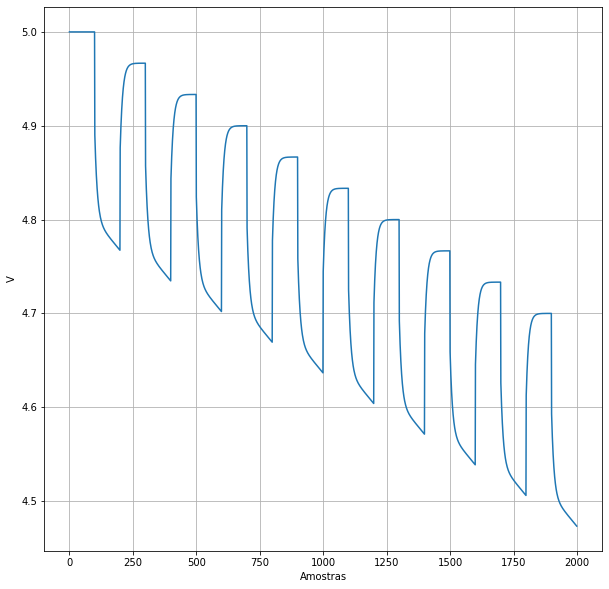

In [8]:
y = V
t = np.arange(len(y))
plt.figure(figsize=(10, 10))
sns.lineplot(x=t, y=y)
plt.ylabel('V')
plt.xlabel('Amostras')
plt.grid()
plt.show()
plt.close()

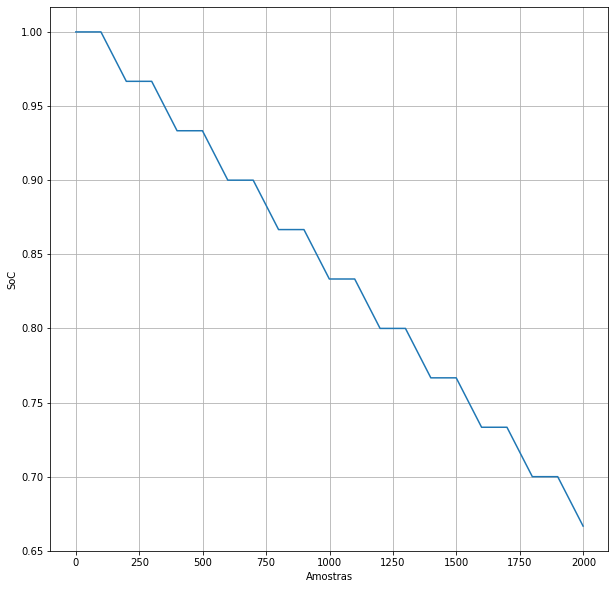

In [9]:
y = Z
t = np.arange(len(y))
plt.figure(figsize=(10, 10))
sns.lineplot(x=t, y=y)
plt.ylabel('SoC')
plt.xlabel('Amostras')
plt.grid()
plt.show()
plt.close()

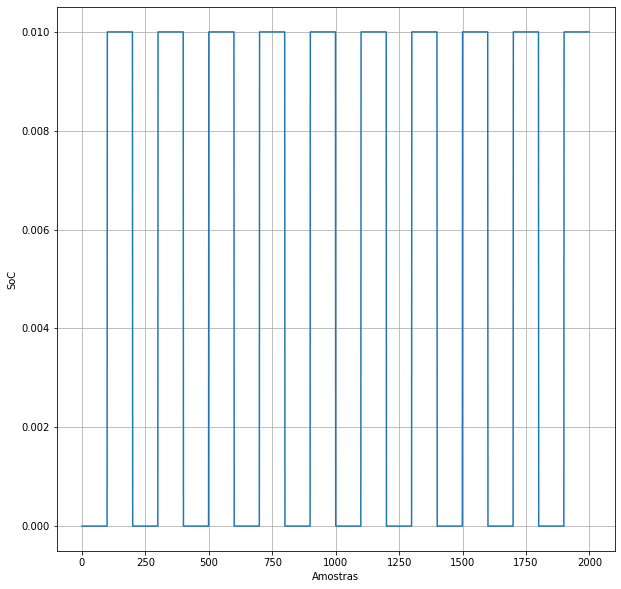

In [10]:
y = I0
t = np.arange(len(y))
plt.figure(figsize=(10, 10))
sns.lineplot(x=t, y=y)
plt.ylabel('SoC')
plt.xlabel('Amostras')
plt.grid()
plt.show()
plt.close()

In [27]:
df = ps.DataFrame(data={'t':t,'V': V, 'I0': I0, 'Z': Z})

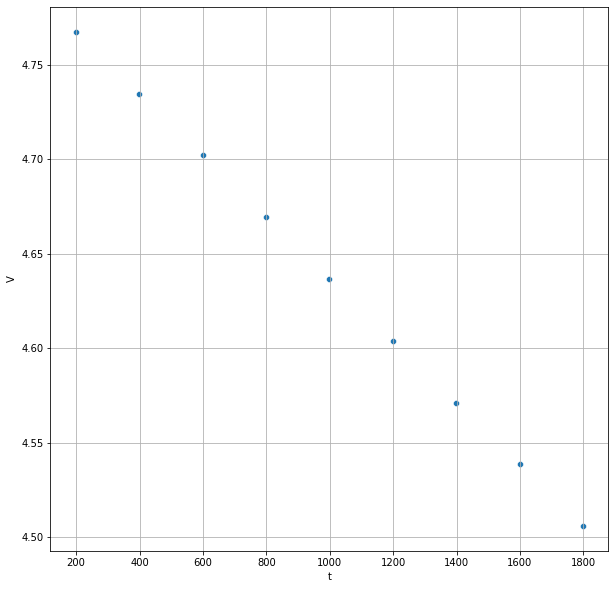

In [34]:
df2 = df[:-1][(df[:-1]['I0'] != df[1:]['I0'])]
df_ovc = df2[df2['I0']==0.01].to_pandas()
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_ovc, x='t', y='V')
plt.grid()
plt.show()
plt.title('OCV')
plt.close()

In [71]:
df_atraso = df[1:].clone()
df_atraso['t'] = df_atraso['t']-1
df2 = df[:-1].join(df_atraso, on='t')
df2['dV'] = df2['V'] - df2['V_right']

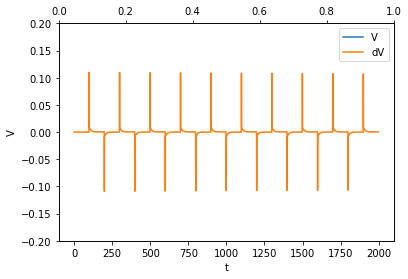

In [80]:
sns.lineplot(data=df2.to_pandas(), x='t', y='V', label='V')
plt.ylim(4.5,5)

p = sns.lineplot(data=df2.to_pandas(), x='t', y='dV', label='dV')
ax2 = p.twiny()
plt.ylim(-0.2,0.2)

plt.show()
plt.close()